In [157]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from shutil import copy2
import random

%load_ext autoreload
%autoreload 2

### Path to this cloned GitHub repo:
SCRIPT_DIR = os.path.dirname('/home/sholtzen/heme_binder_diffusion/')  # edit this to the GitHub repo path. Throws an error by default.
assert os.path.exists(SCRIPT_DIR)
sys.path.append(f"/home/sholtzen/heme_binder_diffusion/scripts/utils/")
import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The pipeline consists of 7 steps:<br>

    0) The protein backbones are generated with RFdiffusionAA
    1) Sequence is designed with proteinMPNN (without the ligand)
    2) Structures are predicted with AlphaFold2
    3) Ligand binding site is designed with LigandMPNN/FastRelax, or Rosetta FastDesign
    4) Sequences surrounding the ligand pocket are diversified with LigandMPNN
    5) Final designed sequences are predicted with AlphaFold2
    6) Alphafold2-predicted models are relaxed with the ligand and analyzed


In [158]:
diffusion_script = f"{SCRIPT_DIR}/rf_diffusion_all_atom/run_inference.py"  # edit this
inpaint_script = f"{SCRIPT_DIR}/RFDesign/inpainting/inpaint.py"  # edit this if needed
proteinMPNN_script = f"{SCRIPT_DIR}/lib/LigandMPNN/run.py"  # from submodule
AF2_script = f"{SCRIPT_DIR}/scripts/af2/af2.py"  # from submodule

### Python and/or Apptainer executables needed for running the jobs
### Please provide paths to executables that are able to run the different tasks.
### They can all be the same if you have an environment with all of the ncessary Python modules in one

# If your added Apptainer does not execute scripts directly,
# try adding 'apptainer run' or 'apptainer run --nv' (for GPU) in front of the command

CONDAPATH = "/home/sholtzen/miniforge3"   # edit this depending on where your Conda environments live
PYTHON = {"diffusion": f"{CONDAPATH}/envs/diffusion/bin/python",
          "af2": f"{CONDAPATH}/envs/mlfold/bin/python",
          "proteinMPNN": f"{CONDAPATH}/envs/diffusion/bin/python",
          "general": f"{CONDAPATH}/envs/diffusion/bin/python"}

## Project description and paths

In [159]:
username='sholtzen'
LIGAND = "ACO"

### Path where the jobs will be run and outputs dumped
WDIR = f"{SCRIPT_DIR}/{LIGAND}_binders/"

if not os.path.exists(WDIR):
    os.makedirs(WDIR, exist_ok=True)

print(f"Working directory: {WDIR}")

USE_GPU_for_AF2 = True


Working directory: /home/sholtzen/heme_binder_diffusion/ACO_binders/


## 0: Setting up diffusion run

In [160]:
# Using example PDB file with ligand HBA and protein 7o2g backbone.
## Note: the repository also contains additional HBA conformers with 7o2g and P450 motifs
## in the same directory as a ZIP file.

random.seed(42)

params = [f"{SCRIPT_DIR}/input/params/{LIGAND}/{LIGAND}.params"]  # Rosetta params file(s)

diffusion_inputs = glob.glob(f"{SCRIPT_DIR}/input/pdbs/{LIGAND}/*_{LIGAND}.pdb")

diffusion_idx = random.sample(range(len(diffusion_inputs)), 20)
diffusion_inputs = [diffusion_inputs[i] for i in diffusion_idx]

print(f"Found {len(diffusion_inputs)} PDB files")

Found 20 PDB files


In [161]:
### Setting up general settings for diffusion
DIFFUSION_DIR = f"{WDIR}0_diffusion"
print(DIFFUSION_DIR)

if not os.path.exists(DIFFUSION_DIR):
    os.makedirs(DIFFUSION_DIR, exist_ok=False)

os.chdir(DIFFUSION_DIR)

N_designs = 30
T_steps = 200

## Edit this config based on motif residues, etc...
config = f"""
defaults:
  - aa
  - _self_

diffuser:
  T: {T_steps}

inference:
  num_designs: {N_designs}
  model_runner: NRBStyleSelfCond
  ligand: '{LIGAND}'
  cuda_core: 0

model:
  freeze_track_motif: True

contigmap:
  contigs: ["120-170"]
  inpaint_str: null

potentials:
  guiding_potentials: ["type:ligand_ncontacts,weight:2"] 
  guide_scale: 2
  guide_decay: quadratic
"""

# assuming 8 seconds per timestep on GTX 1080 and batch size of 3 across two GPUs
estimated_time = 13 * T_steps * N_designs * len(diffusion_inputs) / 10 / 2

print(f"Estimated time to produce {N_designs * len(diffusion_inputs)} designs = {estimated_time/3600:.2f} hours")
with open("config.yaml", "w") as file:
    file.write(config)
print(f"Wrote config file to {os.path.realpath('config.yaml')}")

/home/sholtzen/heme_binder_diffusion/ACO_binders/0_diffusion
Estimated time to produce 600 designs = 21.67 hours
Wrote config file to /home/sholtzen/heme_binder_diffusion/ACO_binders/0_diffusion/config.yaml


In [162]:
commands_diffusion = []
cmds_filename = "commands_diffusion"
diffusion_rundirs = []


with open(cmds_filename, "w") as file:
    for p in diffusion_inputs:
        pdbname = os.path.basename(p).replace(".pdb", "")
        os.makedirs(pdbname, exist_ok=True)
        cmd = f"cd {pdbname} ; {PYTHON['diffusion']} {diffusion_script} --config-dir={DIFFUSION_DIR} "\
              f"--config-name=config.yaml inference.input_pdb={p} "\
              f"inference.output_prefix='./out/{pdbname}_dif' "
        commands_diffusion.append(cmd)
        diffusion_rundirs.append(pdbname)
        file.write(cmd)

In [ ]:
## Setting up diffusion commands based on the input PDB file(s)
## Diffusion jobs are run in separate directories for each input PDB
from threadpoolctl import threadpool_limits, threadpool_info

import time

# Rudimentary CUDA scheduler...

# Instantiate cuda and process lists

batch_size = 10
num_cuda_cores = [6,7]

open_cuda = []
taken_cuda = []
processes = []

# Create open cuda list with all avaialble cuda cores
for cuda in num_cuda_cores:
    for batch in range(batch_size):
        open_cuda.append(cuda)  

        
# Iterate through `commands_diffusion` variable until there are no commands left
while commands_diffusion:

    # Take a census of the open CUDA to see that they're not at batch size
    census_cuda = [taken_cuda.count(0), taken_cuda.count(1)]
    for i, ele in enumerate(census_cuda):
        print(f'{ele} processes on core {i}.') 
    
    cuda_maxed = all(ele==batch_size for ele in census_cuda)

    # iterate through the open cuda cores for as long as there are open cores and they're not maxed
    while open_cuda and not cuda_maxed and commands_diffusion:

        # Pluck command and cuda core pair
        command = commands_diffusion.pop(0)
        cuda_core = open_cuda.pop(0)

        # Assign that cuda core to the list of taken cores
        taken_cuda.append(cuda_core)        

        # Write commands with that assigned core and create a subprocess on that core
        command += f"inference.cuda_core={cuda_core} "
        command += "> output.log ; cd ..\n"
        with threadpool_limits(limits=1):
            processes.append(subprocess.Popen(command, shell=True))

        print(f'Diffusing backbone based on PDB {command[3:7]}, running on CUDA core {cuda_core}...')

    # Sleep while all processes are running
    while all([process.poll() is None for process in processes]):
        time.sleep(1)

    # Once any process is done, identify that process as the index of the process list (and by extension, the cuda core it's assigned to)
    done_cuda = [i for i, x in enumerate(processes) if x.poll() is not None]

    print(f'Process {done_cuda[0]} is done, switching...')

    # Get out the index of that process's cuda core in the `taken_cuda` variable
    index_cuda = done_cuda.pop(0)
    processes.pop(index_cuda)

    # Which cuda core are we talking about?
    move_cuda = taken_cuda[index_cuda]

    # Append `move_cuda` to `open_cuda` and remove that core from `taken_cuda`
    open_cuda.append(move_cuda)
    taken_cuda.pop(index_cuda)

print('All done!')
        

In [163]:
## If you're done with diffusion and happy with the outputs then mark it as done
DIFFUSION_DIR = f"{WDIR}/0_diffusion"
os.chdir(DIFFUSION_DIR)

if not os.path.exists(DIFFUSION_DIR+"/.done"):
    with open(f"{DIFFUSION_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing diffusion outputs
The purpose of this step is to identify diffused backbones that meet certain quality criteria. These scaffolds should be relatively globular (measured by radius of gyration (rog), and longest helix). They should not have clashes between the ligand and the backbone, the ligand should not be too exposed (measured by relative SASA). The termini should not be too close to the ligand (term_mindist), and the backbone should not be too loopy. In the example below we are also looking for backbones that leave some part of the ligand more exposed.

In [166]:
### Analyzing diffusion outputs for clashes, ligand burial and scaffold quality
## If it's running too slowly consider increasing --nproc
analysis_script = f"{SCRIPT_DIR}/scripts/diffusion_analysis/process_diffusion_outputs.py"

diffusion_outputs = []
diffusion_count = 0
for d in diffusion_rundirs:
    diffusion_outputs += glob.glob(f"{d}/out/*.pdb")
    diffusion_count += len(glob.glob(f"{d}/out/*.pdb"))
    
print(f"{diffusion_count} backbones to analyze")

# By default I don't use the --analyze flag. As a result the backbones are filtered as the script runs.

dif_analysis_cmd_dict = {"--pdb": " ".join(diffusion_outputs),
                        "--params": " ".join(params),
                        "--term_limit": "10.0",
                        "--SASA_limit": "0.4",  # Highest allowed relative SASA of ligand
                        "--loop_limit": "0.4",  # Fraction of backbone that can be loopy
                        "--rethread": True,
                        "--longest_helix": "30",
                        "--rog": "30.0",
                        "--fix": True,
                        "--partial": None,
                        "--outdir": None,
                        "--traj": "5/30",  # Also random 5 models are taken from the last 30 steps of the diffusion trajectory
                        "--analyze": False,
                        "--nproc": "8"}

analysis_command = f"{PYTHON['general']} {analysis_script}"

for k, val in dif_analysis_cmd_dict.items():
    if val is not None:
        if isinstance(val, list):
            analysis_command += f" {k}"
            analysis_command += " " + " ".join(val)
        elif isinstance(val, bool):
            if val == True:
                analysis_command += f" {k}"
        else:
            analysis_command += f" {k} {val}"

p = subprocess.Popen(analysis_command, shell=True)
(output, err) = p.communicate()

diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")

dif_analysis_df = pd.read_csv(f"{DIFFUSION_DIR}/diffusion_analysis.sc", header=0, sep=r"\s+")

Sorting the matches took 73.446 seconds.
     chainbreak loop_frac  ...    ncdist                             description
414    3.895936  0.291925  ...  4.673574        2ZFN_ACO/out/2ZFN_ACO_dif_15.pdb
456     3.85726  0.167939  ...  5.264667  3CSC_ACO/out/3CSC_ACO_dif_13_traj1.pdb
899     3.86079  0.167939  ...  5.413387  3CSC_ACO/out/3CSC_ACO_dif_13_traj2.pdb
36     3.871651  0.273333  ...  6.236213        9F5Q_ACO/out/9F5Q_ACO_dif_13.pdb
1342   3.859562  0.167939  ...  6.541252  3CSC_ACO/out/3CSC_ACO_dif_13_traj3.pdb
...         ...       ...  ...       ...                                     ...
406    3.872278  0.459854  ...       NaN         2ZFN_ACO/out/2ZFN_ACO_dif_7.pdb
818    3.848911  0.465116  ...       NaN  7DQG_ACO/out/7DQG_ACO_dif_20_traj1.pdb
1657   3.870001  0.474026  ...       NaN  7WTE_ACO/out/7WTE_ACO_dif_17_traj3.pdb
1214   3.896988  0.474026  ...       NaN  7WTE_ACO/out/7WTE_ACO_dif_17_traj2.pdb
619    3.862257  0.528455  ...       NaN  8G1E_ACO/out/8G1E_ACO_dif_

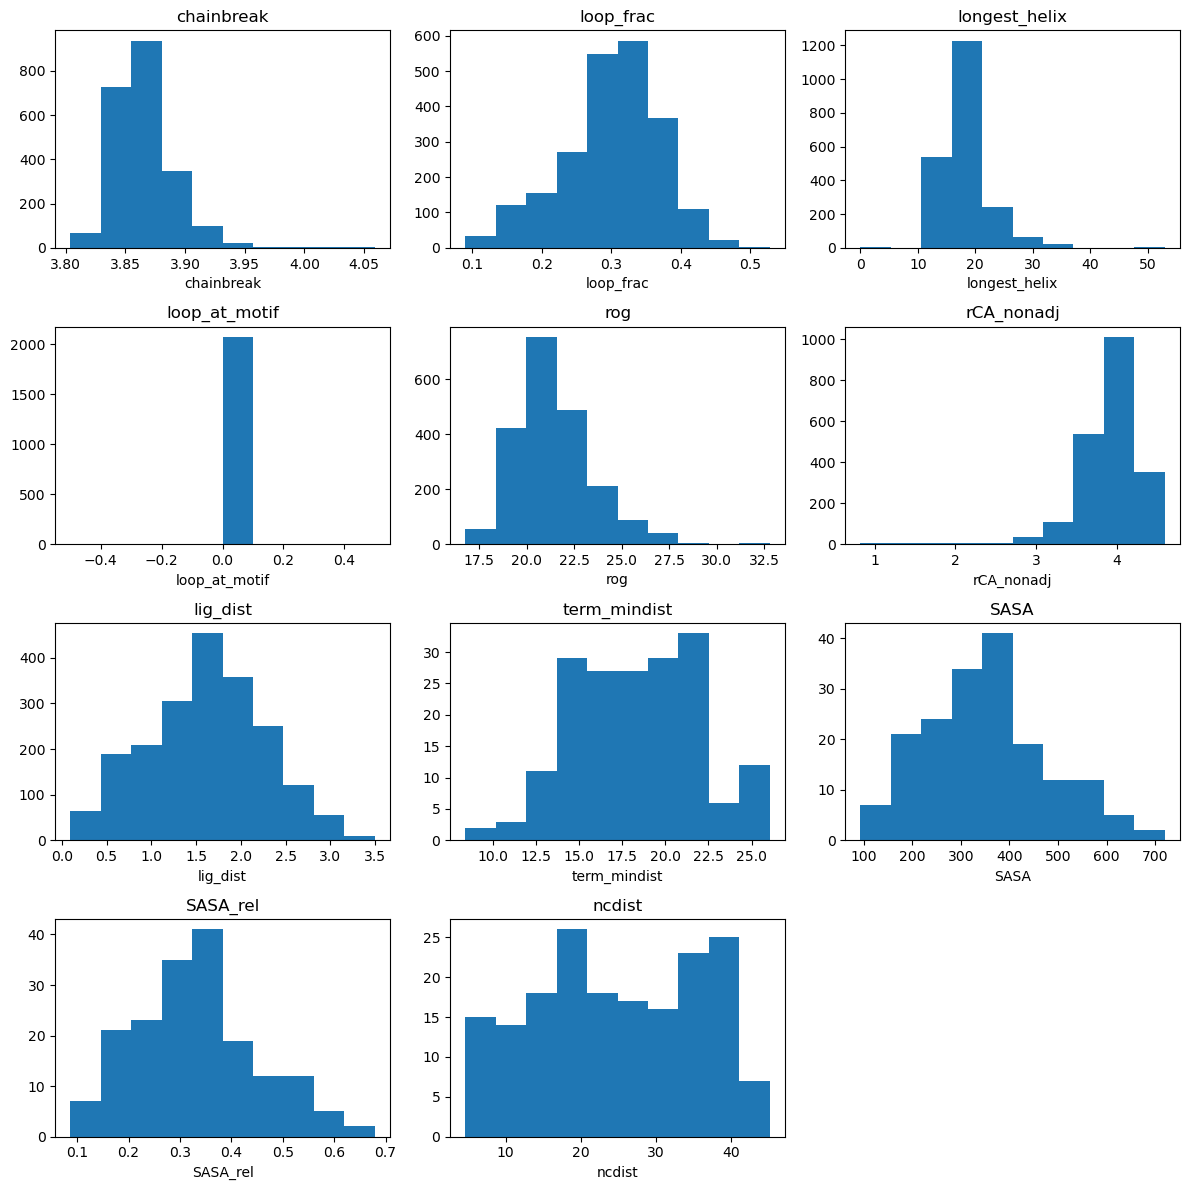

In [167]:
## Visualizing the distributions of diffusion analysis metrics
## Plotting design scores
plt.figure(figsize=(12, 12))
for i,k in enumerate(dif_analysis_df.keys()):
    if k in ["description"]:
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(dif_analysis_df[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

It is highly advised that you manually inspect the filtered diffusion outputs before continuing with the pipeline.
While the filters attempt to pick out the most offending designs then nothing beats your own intuition and judgement.

## 1: Running ProteinMPNN on diffused backbones

We are first trying to just design a sequence on the backbone, without considering the ligand.
The goal is to first find backbones that fold well.

In [ ]:
diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")
assert len(diffused_backbones_good) > 0, "No good backbones found!"

os.chdir(WDIR)

MPNN_DIR = f"{WDIR}/1_proteinmpnn"
os.makedirs(MPNN_DIR, exist_ok=True)
os.chdir(MPNN_DIR)

In [ ]:
### Parsing diffusion output TRB files to extract fixed motif residues
## These residues will not be redesigned with proteinMPNN
mask_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/make_maskdict_from_trb.py --out masked_pos.jsonl --trb"
for d in diffused_backbones_good:
    mask_json_cmd += " " + d.replace(".pdb", ".trb")
p = subprocess.Popen(mask_json_cmd, shell=True)
(output, err) = p.communicate()

assert os.path.exists("masked_pos.jsonl"), "Failed to create masked positions JSONL file"


### Setting up proteinMPNN run commands
## We're doing design with 3 temperatures, and 5 sequences each.
## This usually gives decent success with designable backbones.
## For more complicated cases consider doing >100 sequences.

MPNN_temperatures = [0.1, 0.2, 0.3]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "M"

commands_mpnn = []
for T in MPNN_temperatures:
    for f in diffused_backbones_good:
        commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                             f"--model_type protein_mpnn --ligand_mpnn_use_atom_context 0 "
                             "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                             f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                             f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                             f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt ")

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running proteinMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.
batch_size = 10
num_cuda_cores = [5,6]

open_cuda = []
taken_cuda = []
processes = []

# Create open cuda list with all avaialble cuda cores
for cuda in num_cuda_cores:
    for batch in range(batch_size):
        open_cuda.append(cuda)  

        
# Iterate through `commands_diffusion` variable until there are no commands left
while commands_mpnn:

    # Take a census of the open CUDA to see that they're not at batch size
    census_cuda = [taken_cuda.count(0), taken_cuda.count(1)]
    for i, ele in enumerate(census_cuda):
        print(f'{ele} processes on core {i}.') 
    
    cuda_maxed = all(ele==batch_size for ele in census_cuda)

    # iterate through the open cuda cores for as long as there are open cores and they're not maxed
    while open_cuda and not cuda_maxed and commands_mpnn:

        # Pluck command and cuda core pair
        command = commands_mpnn.pop(0)
        cuda_core = open_cuda.pop(0)

        # Assign that cuda core to the list of taken cores
        taken_cuda.append(cuda_core)        

        # Write commands with that assigned core and create a subprocess on that core
        command += f"--cuda_core {cuda_core} "
        with threadpool_limits(limits=1):
            processes.append(subprocess.Popen(command, shell=True))

        print(f'Diffusing backbone based on PDB {command[3:7]}, running on CUDA core {cuda_core}...')

    # Sleep while all processes are running
    while all([process.poll() is None for process in processes]):
        time.sleep(1)

    # Once any process is done, identify that process as the index of the process list (and by extension, the cuda core it's assigned to)
    done_cuda = [i for i, x in enumerate(processes) if x.poll() is not None]

    print(f'Process {done_cuda[0]} is done, switching...')

    # Get out the index of that process's cuda core in the `taken_cuda` variable
    index_cuda = done_cuda.pop(0)
    processes.pop(index_cuda)

    # Which cuda core are we talking about?
    move_cuda = taken_cuda[index_cuda]

    # Append `move_cuda` to `open_cuda` and remove that core from `taken_cuda`
    open_cuda.append(move_cuda)
    taken_cuda.pop(index_cuda)

print('All done!')

In [ ]:
## If you're done with diffusion and happy with the outputs then mark it as done
MPNN_DIR = f"{WDIR}/1_proteinmpnn"
os.chdir(MPNN_DIR)

if not os.path.exists(MPNN_DIR+"/.done"):
    with open(f"{MPNN_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


## 2: Running AlphaFold2
Performing AF2 single sequence predictions.<br>
By default only using AF2 model 4 with 3 recycles. For more complicated folds 10+ recycles might be necessary.

In [ ]:
os.chdir(WDIR)

AF2_DIR = f"{WDIR}/2_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{MPNN_DIR}/seqs/*.fa"))
mpnn_fasta = {k: seq.strip() for k, seq in mpnn_fasta.items() if "model_path" not in k}  # excluding the diffused poly-A sequence
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
mpnn_fasta = {k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", ""): seq for k, seq in mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

with open('all_seq.fasta', 'w') as file:
    for k in mpnn_fasta:
        file.write(f"{k}\n{mpnn_fasta[k]}\n")

SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)

In [ ]:
## Setting up AlphaFold2 run
from threadpoolctl import threadpool_limits
AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1]) 

with open(cmds_filename_af2, 'r') as file:
    for line in file:
        with threadpool_limits(limits=1):
            p = subprocess.Popen(line, shell=True)
            (output, err) = p.communicate()

In [ ]:
## If you're done with diffusion and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/2_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
AF2_DIR = f"{WDIR}/2_af2"
DIFFUSION_DIR = f"{WDIR}/0_diffusion"

os.system("head -n 1 $(ls all_seq.csv | shuf -n 1) > scores.csv ; for f in all_seq.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DIFFUSION_DIR}/filtered_structures/ --mpnn --params {' '.join(params)} --nproc 4"

## Analyzing locally
p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()

In [ ]:
scores_af2 = pd.read_csv("scores.sc", sep=r"\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [80.0, ">="],
               "rmsd": [3, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


### Aligning the ligand back into the AF2 predictions.
### This is done by aligning the AF2 model to diffusion output and copying over the ligand using PyRosetta.
### --fix_catres option will readjust the rotamer and tautomer of 
### any catalytic residue to be the same as in the reference model.

align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/place_ligand_after_af2.py "\
            f"--outdir with_{LIGAND} --params {' '.join(params)} --fix_catres "\
            f"--pdb {' '.join(good_af2_models)} "\
            f"--ref {' '.join(glob.glob(DIFFUSION_DIR+'/filtered_structures/*.pdb'))}"

p = subprocess.Popen(align_cmd, shell=True)
(output, err) = p.communicate()

## 3.1: Performing binding site design with ligandMPNN / FastRelax
(see 3.2 down below for design with [Rosetta FastDesign](#Rosetta_design))

In [ ]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
os.makedirs(DESIGN_DIR_ligMPNN, exist_ok=True)
os.chdir(DESIGN_DIR_ligMPNN)

AF2_DIR = f"{WDIR}/2_af2"
os.makedirs(DESIGN_DIR_ligMPNN+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure

NSTRUCT = 5
commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_{LIGAND}/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_ligMPNN.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} --design_full --nproc 2 "
                             f"--scoring {SCRIPT_DIR}/scripts/design/scoring/heme_scoring.py "
                             f"--params {' '.join(params)} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])

import time

processes=[]
batch_size=10

while commands_design:

    # Take a census of the open processes to see that they're not at batch size

    curr_proc = len(processes)
    proc_maxed = curr_proc <= batch_size
    
    # iterate through the open cuda cores for as long as there are open cores and they're not maxed
    while proc_maxed and commands_design:

        # Pluck command and cuda core pair
        command = commands_design.pop(0) 
        curr_proc = len(processes)
        proc_maxed = curr_proc <= batch_size
        print(f"Running command:\n{command}")
        processes.append(subprocess.Popen(command, shell=True))
                
    # Sleep while all processes are running
    while all([process.poll() is None for process in processes]):
        time.sleep(1)

    # Once any process is done, identify that process as the index of the process list
    processes = [x for x in processes if x.poll() is None]
    

print('All done!')

### Running design jobs with Slurm.
# submit_script = "submit_design.sh"
# utils.create_slurm_submit_script(filename=submit_script, name="3.1_design_pocket_ligMPNN", mem="4g", 
#                                  N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
#                                  array_commandfile=cmds_filename_des)

# if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
#     p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     (output, err) = p.communicate()

In [ ]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
os.chdir(DESIGN_DIR_ligMPNN)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    with open(f"{DESIGN_DIR_ligMPNN}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing ligMPNN / FastRelax design results

In [ ]:
## Analyzing ligMPNN / FastRelax designs
if not os.path.exists("scorefile.txt"):
    sys.exit("Design job failed, or no successful outputs were produced.")

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-2.0, '<='],
 'cms_per_atom': [4, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting AF2 scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ligMPNN}/good")
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.1 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()

### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "M"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_ligand_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

In [ ]:
### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.
batch_size = 10
num_cuda_cores = [6,7]

open_cuda = []
taken_cuda = []
processes = []

# Create open cuda list with all avaialble cuda cores
for cuda in num_cuda_cores:
    for batch in range(batch_size):
        open_cuda.append(cuda)  

        
# Iterate through `commands_diffusion` variable until there are no commands left
while commands_mpnn:

    # Take a census of the open CUDA to see that they're not at batch size
    census_cuda = [taken_cuda.count(0), taken_cuda.count(1)]
    for i, ele in enumerate(census_cuda):
        print(f'{ele} processes on core {i}.') 
    
    cuda_maxed = all(ele==batch_size for ele in census_cuda)

    # iterate through the open cuda cores for as long as there are open cores and they're not maxed
    while open_cuda and not cuda_maxed and commands_mpnn:

        # Pluck command and cuda core pair
        command = commands_mpnn.pop(0)
        cuda_core = open_cuda.pop(0)

        # Assign that cuda core to the list of taken cores
        taken_cuda.append(cuda_core)        

        # Write commands with that assigned core and create a subprocess on that core
        command += f"--cuda_core {cuda_core} "
        with threadpool_limits(limits=1):
            processes.append(subprocess.Popen(command, shell=True))

        print(f'Diffusing backbone based on PDB {command[3:7]}, running on CUDA core {cuda_core}...')

    # Sleep while all processes are running
    while all([process.poll() is None for process in processes]):
        time.sleep(1)

    # Once any process is done, identify that process as the index of the process list (and by extension, the cuda core it's assigned to)
    done_cuda = [i for i, x in enumerate(processes) if x.poll() is not None]

    print(f'Process {done_cuda[0]} is done, switching...')

    # Get out the index of that process's cuda core in the `taken_cuda` variable
    index_cuda = done_cuda.pop(0)
    processes.pop(index_cuda)

    # Which cuda core are we talking about?
    move_cuda = taken_cuda[index_cuda]

    # Append `move_cuda` to `open_cuda` and remove that core from `taken_cuda`
    open_cuda.append(move_cuda)
    taken_cuda.pop(index_cuda)

print('All done!')


In [132]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"
os.chdir(DESIGN_DIR_2nd_mpnn)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    with open(f"{DESIGN_DIR_2nd_mpnn}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"
assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

with open('all_seq2.fasta', 'w') as file:
    for k in mpnn_fasta:
        file.write(f"{k}\n{mpnn_fasta[k]}\n")

A total on 984 sequences will be predicted.


## 5.1 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1]) 

with open(cmds_filename_af2, 'r') as file:
    for line in file:
        with threadpool_limits(limits=1):
            p = subprocess.Popen(line, shell=True)
            (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.chdir(AF2_DIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls all_seq2.csv | shuf -n 1) > scores.csv ; for f in all_seq2.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ligMPNN}/good/ --mpnn --params {' '.join(params)} --nproc 4"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


lDDT                     >=  85.000: 303 items left. 303 pass (31%).
rmsd                     <=   1.200: 147 items left. 153 pass (16%).


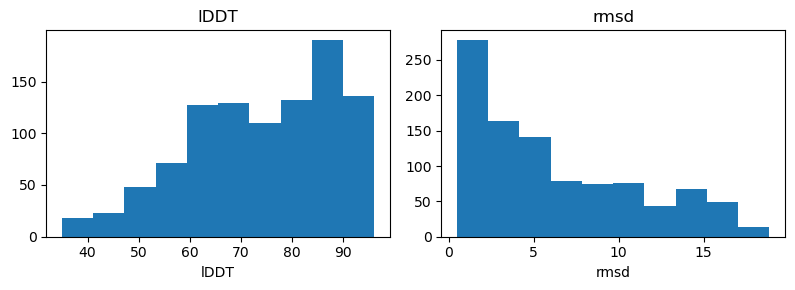

Plotting lDDT vs rmsd.


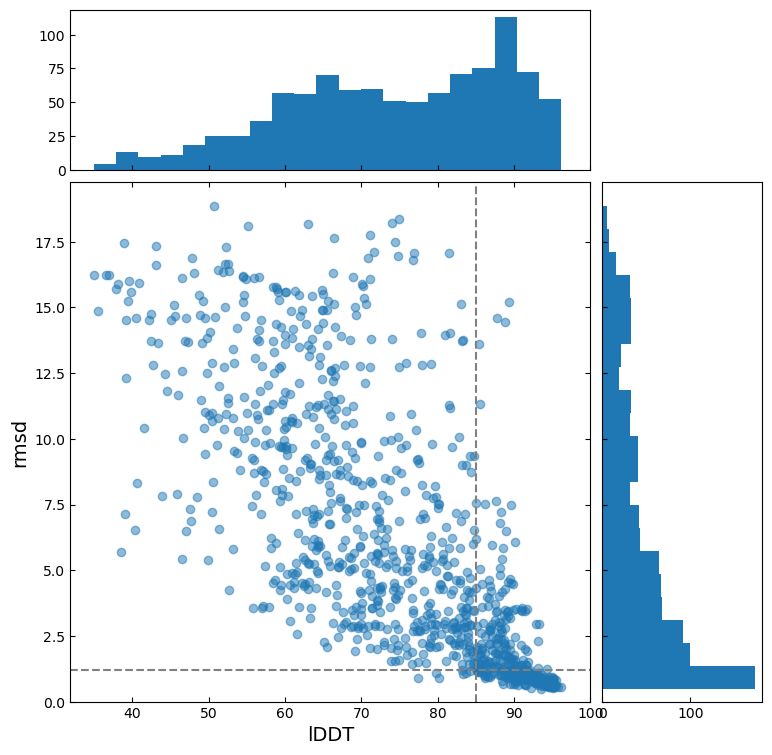

In [138]:
### Visualizing and filtering AF2 results
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.chdir(AF2_DIR)

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="]}

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [139]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")


## 6.1: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [147]:
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)

os.makedirs(RELAX_DIR+"/logs", exist_ok=True)

## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ligMPNN}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


In [148]:
## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1

commands_relax = []
cmds_filename_rlx = "commands_relax"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]} "
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} --nproc 2 "
                              f"--params {' '.join(params)} > logs/{os.path.basename(r_m[1]).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_relax[-1])

processes=[]
batch_size=10

while commands_relax:

    # Take a census of the open processes to see that they're not at batch size

    curr_proc = len(processes)
    proc_maxed = curr_proc <= batch_size
    
    # iterate through the open cuda cores for as long as there are open cores and they're not maxed
    while proc_maxed and commands_relax:

        # Pluck command and cuda core pair
        command = commands_relax.pop(0) 
        curr_proc = len(processes)
        proc_maxed = curr_proc <= batch_size
        processes.append(subprocess.Popen(command, shell=True))
                
    # Sleep while all processes are running
    while all([process.poll() is None for process in processes]):
        time.sleep(1)

    # Once any process is done, identify that process as the index of the process list
    processes = [x for x in processes if x.poll() is None]
    

print('All done!')

Running command:
/home/sholtzen/miniforge3/envs/diffusion/bin/python /home/sholtzen/heme_binder_diffusion/scripts/design/align_add_ligand_relax.py --outdir ./ --ligand ACO --ref_pdb /home/sholtzen/heme_binder_diffusion/ACO_binders//3.1_design_pocket_ligandMPNN/good/7DQG_ACO_dif_16_traj4_T0.3_0_4_model_4.0_r3_af2_ACO_mDE_4.pdb --pdb /home/sholtzen/heme_binder_diffusion/ACO_binders//5.1_2nd_af2/good/7DQG_ACO_dif_16_traj4_T0.3_0_4_model_4.0_r3_af2_ACO_mDE_4_T0.2_0_5_model_4.0_r3_af2.pdb --nstruct 1 --nproc 2 --params /home/sholtzen/heme_binder_diffusion/input/params/ACO/ACO.params > logs/7DQG_ACO_dif_16_traj4_T0.3_0_4_model_4.0_r3_af2_ACO_mDE_4_T0.2_0_5_model_4.0_r3_af2.log

All done!


In [150]:
## If you're done with final relax and happy with the outputs then mark it as done
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.chdir(RELAX_DIR)

if not os.path.exists(RELAX_DIR+"/.done"):
    with open(f"{RELAX_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

L_SASA                   <=   0.200: 114 items left. 114 pass (78%).
score_per_res            <=   0.000: 114 items left. 147 pass (100%).
corrected_ddg            <=  -2.000: 114 items left. 147 pass (100%).
rmsd_CA_rlx_in           <=   1.000: 105 items left. 133 pass (90%).


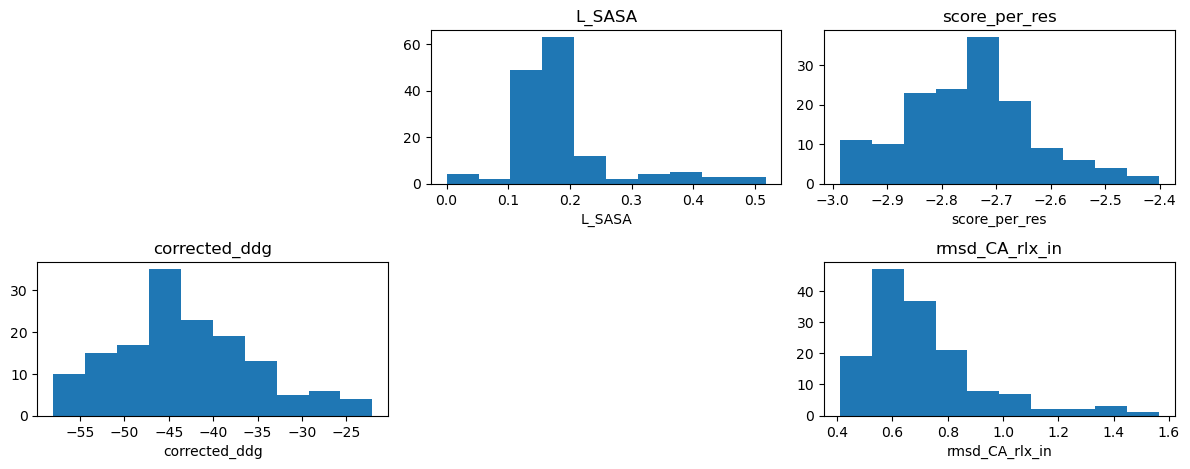

In [155]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep=r"\s+", header=0)

filters = {
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-2.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [152]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")

CONGRATULATIONS! You have successfully designed 27 proteins against ligand ACO
You can find the design models in the directory:
    /home/sholtzen/heme_binder_diffusion/ACO_binders//6.1_final_relax/good

It is advised you manually inspect them before ordering.


# End of pipeline